Create the dataset/ download them

I will adapted https://www.kaggle.com/theimgclist/multiclass-food-classification-using-tensorflow to create the ML code

In [ ]:
! pip install -q kaggle


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import requests, re, time
import torch, torchvision
from torch import nn, optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import numpy as np



In [ ]:
import keras

from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics

from sklearn.utils import class_weight
from collections import Counter

import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

import pandas as pd

In [ ]:


# Helper function to download data and extract
def get_data_extract():
  if "Indian Food Images" in os.listdir():
    print("Dataset already exists")
  else:
    print("Getting kaggle API token")
    !cp /content/drive/MyDrive/CPEN391_team_penguin/kaggle.json ~/.kaggle/kaggle.json
    print("Kaggle API token goten!")
    print("Downloading the data...")
    !kaggle datasets download -d iamsouravbanerjee/indian-food-images-dataset -p /content/
    print("Dataset downloaded!")
    print("Extracting data..")
    !unzip indian-food-images-dataset.zip
    print("Extraction done!")



In [ ]:
get_data_extract()
get_data_extract()

Dataset already exists
Dataset already exists


In [ ]:
dataset_full_loc = 'Indian Food Images/Indian Food Images'
os.listdir(dataset_full_loc)

['gavvalu',
 'chikki',
 'kofta',
 'karela_bharta',
 'rasgulla',
 'dum_aloo',
 'lassi',
 'paneer_butter_masala',
 'mysore_pak',
 'anarsa',
 'aloo_gobi',
 'gulab_jamun',
 'dharwad_pedha',
 'chhena_kheeri',
 'chana_masala',
 'sohan_halwa',
 'malapua',
 'aloo_shimla_mirch',
 'shankarpali',
 'unni_appam',
 'sheer_korma',
 'kakinada_khaja',
 'lyangcha',
 'imarti',
 'butter_chicken',
 'dal_tadka',
 'sohan_papdi',
 'chicken_tikka',
 'basundi',
 'cham_cham',
 'ledikeni',
 'doodhpak',
 'qubani_ka_meetha',
 'ariselu',
 'kajjikaya',
 'adhirasam',
 'litti_chokha',
 'misti_doi',
 'gajar_ka_halwa',
 'rabri',
 'chicken_razala',
 'daal_baati_churma',
 'aloo_tikki',
 'kadhi_pakoda',
 'pootharekulu',
 'dal_makhani',
 'kachori',
 'makki_di_roti_sarson_da_saag',
 'double_ka_meetha',
 'aloo_methi',
 'poornalu',
 'bandar_laddu',
 'boondi',
 'bhindi_masala',
 'palak_paneer',
 'aloo_matar',
 'ras_malai',
 'daal_puri',
 'navrattan_korma',
 'sheera',
 'maach_jhol',
 'phirni',
 'bhatura',
 'biryani',
 'kalakand',

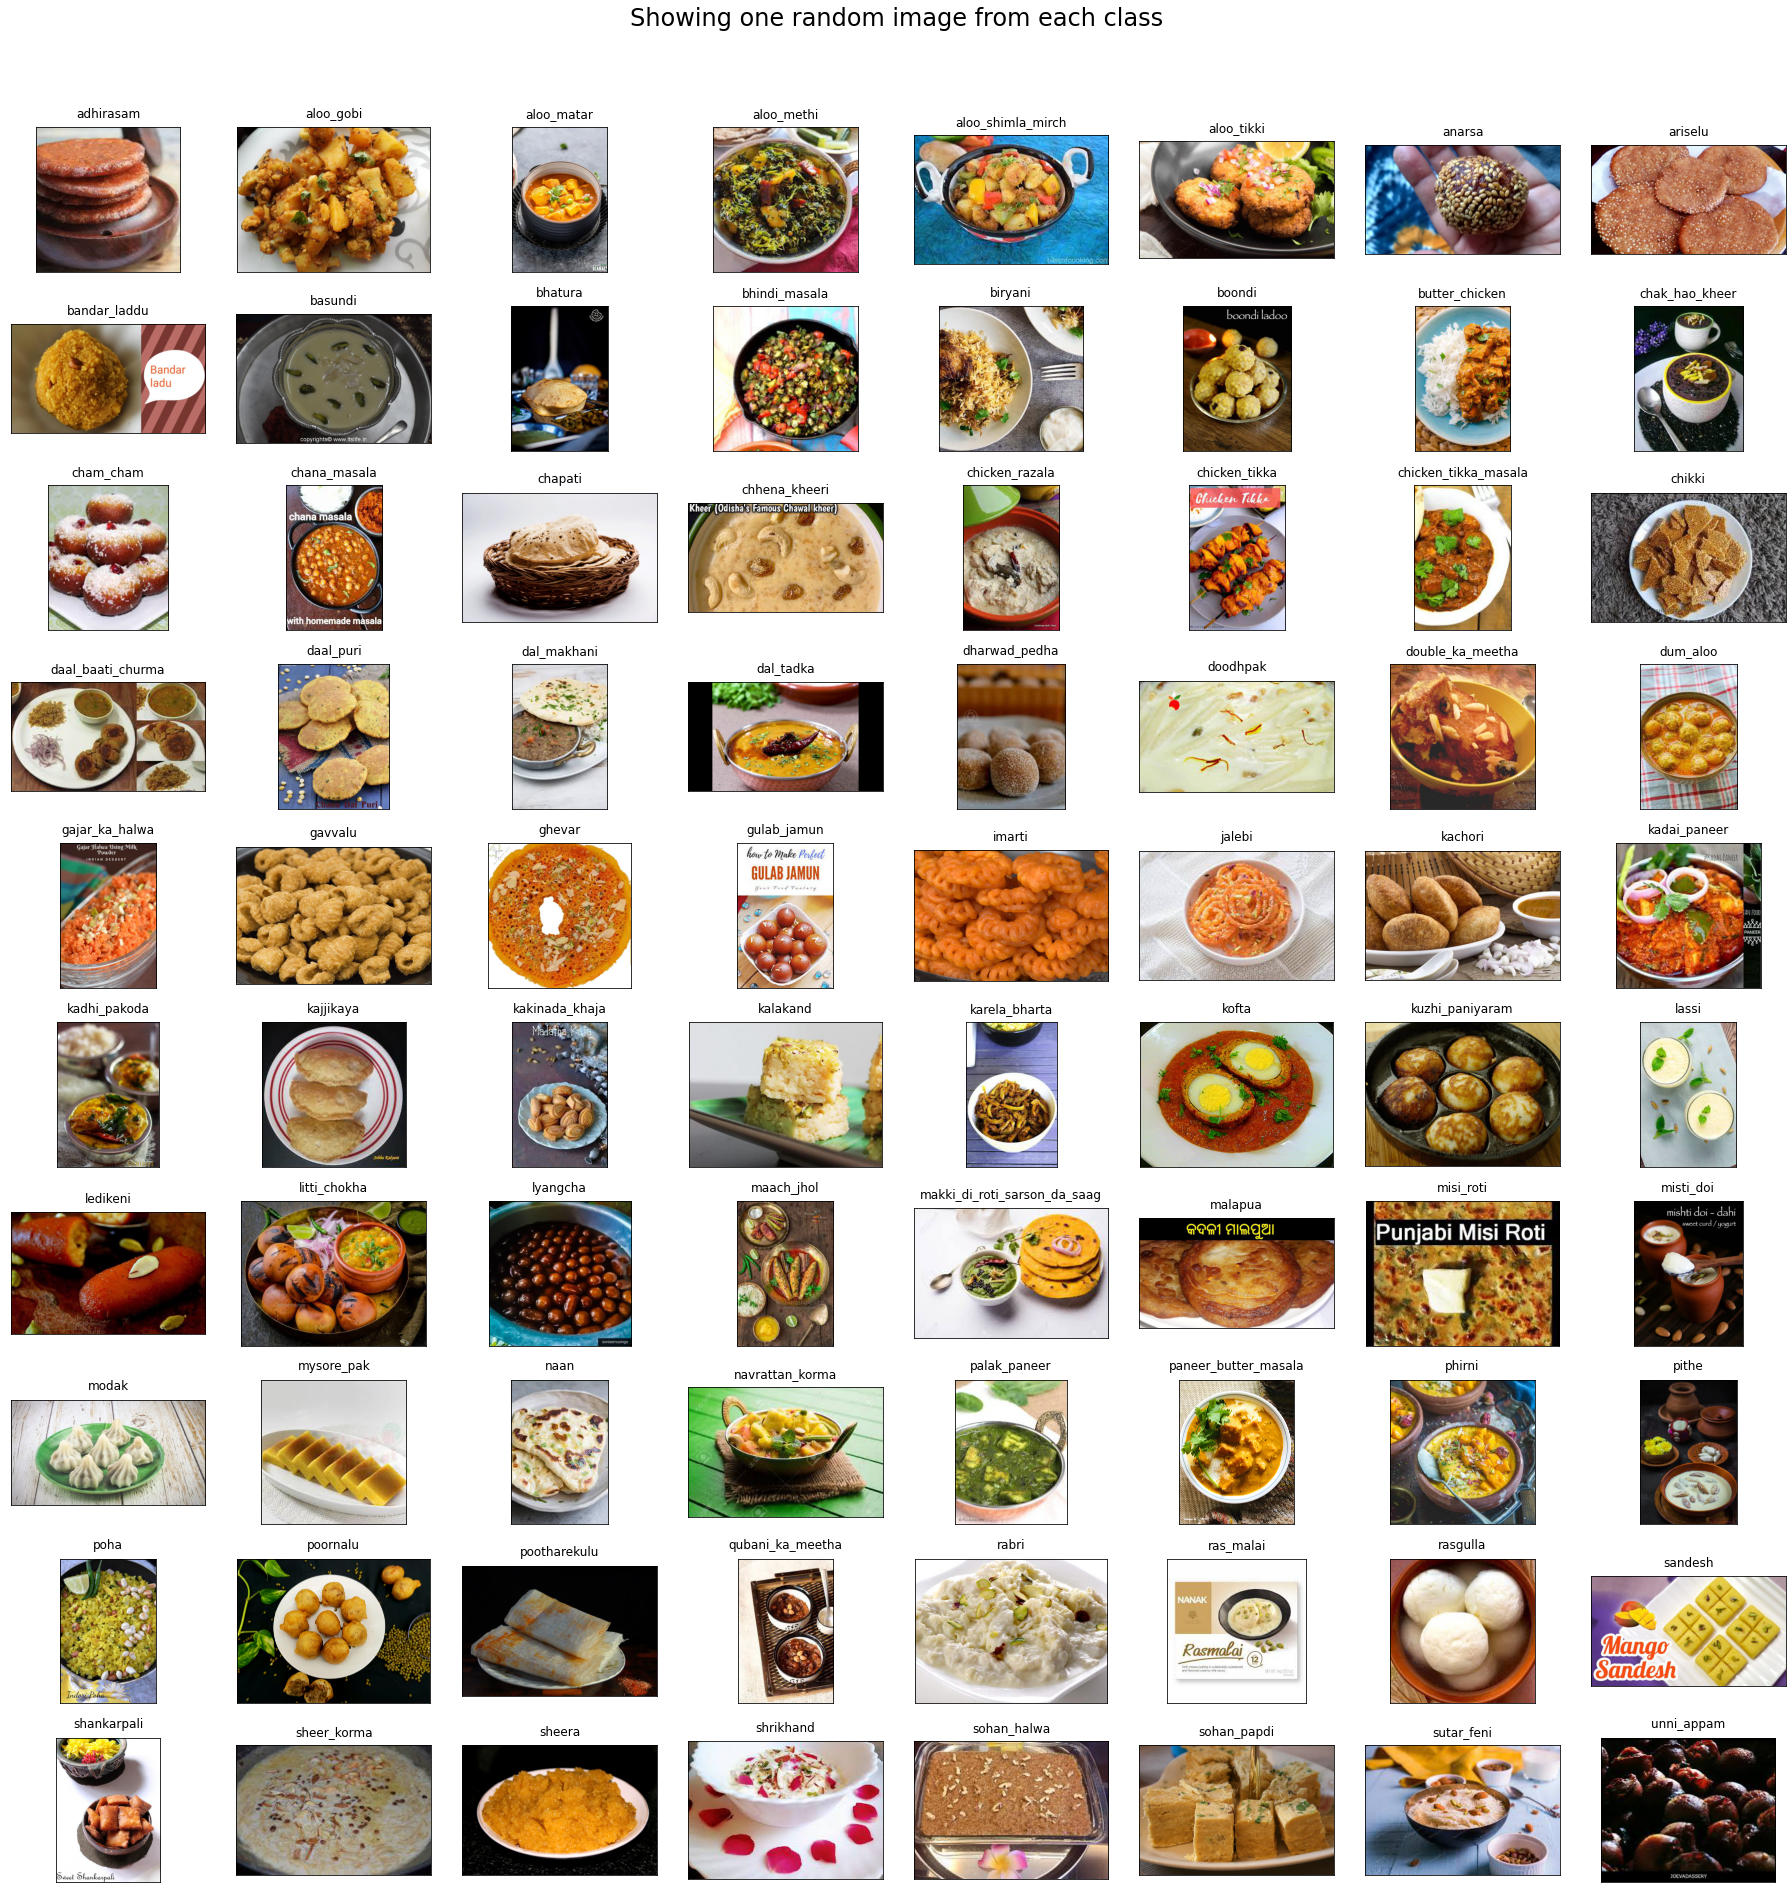

In [ ]:
# Visualize the data, showing one image per class from 80 classes
rows = 10
cols = 8
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = dataset_full_loc
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
#plt.savefig('/content/drive/MyDrive/CPEN391_team_penguin/random_img_classes.svg', format='svg', dpi=1200)
plt.tight_layout()

# https://matplotlib.org/users/tight_layout_guide.html

In [ ]:
trdata = ImageDataGenerator(validation_split=0.2) #20% of the images are for validation while rest are for training
testdata = trdata.flow_from_directory(directory=dataset_full_loc, target_size=(224,224),subset='validation') #vgg16 accepts 224 by 224 pixels,
traindata = trdata.flow_from_directory(directory=dataset_full_loc, target_size=(224,224),subset='training')

Found 800 images belonging to 80 classes.
Found 3200 images belonging to 80 classes.


In [ ]:
vgg16 =  VGG16(weights='imagenet') #load weights from imagenet pretrained vgg16
vgg16.summary()


553476096/553467096 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
#the below code changes the fully connected layer to have the below layer
x  = vgg16.get_layer('fc2').output
prediction = Dense(80, activation='softmax', name='predictions')(x) # the output is set to 80 because we have 80 classes
#using Model from tensorflow,
model = Model(inputs=vgg16.input, outputs=prediction)

In [ ]:
#Since the vgg16 is trained with normal image data, we need to retrain most of the layers for food data
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]: #set only the last few layers to trainable
    layer.trainable = True
    print("Layer '%s' is trainable" % layer.name)

Layer 'block4_conv1' is trainable
Layer 'block4_conv2' is trainable
Layer 'block4_conv3' is trainable
Layer 'block4_pool' is trainable
Layer 'block5_conv1' is trainable
Layer 'block5_conv2' is trainable
Layer 'block5_conv3' is trainable
Layer 'block5_pool' is trainable
Layer 'flatten' is trainable
Layer 'fc1' is trainable
Layer 'fc2' is trainable
Layer 'predictions' is trainable


In [ ]:
optimizer_learning_rate = 0.00001
opt = Adam(learning_rate=optimizer_learning_rate) #small learning rate with below parameters allows the model to pick between small diffrences between categories, prev 0.000001
model.compile(optimizer=opt, loss=categorical_crossentropy, #the model will work with ADAM and cross entrophy
              metrics=['accuracy', 'mae'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#A check point system that saves the model when there is improvement inside an epoch
checkpoint = ModelCheckpoint("vgg16_base_res.h5", monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto')
#Below code stops the training function to stop early if there is no improvement between epochs
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

In [ ]:
#we calculate weights for each class as our amount of data is imbalanced
# here there are equal images for each class, use this code in the future if there is imbalance
counter = Counter(traindata.classes)                       
max_val = float(max(counter.values()))   
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 1.0,
 1: 1.0,
 2: 1.0,
 3: 1.0,
 4: 1.0,
 5: 1.0,
 6: 1.0,
 7: 1.0,
 8: 1.0,
 9: 1.0,
 10: 1.0,
 11: 1.0,
 12: 1.0,
 13: 1.0,
 14: 1.0,
 15: 1.0,
 16: 1.0,
 17: 1.0,
 18: 1.0,
 19: 1.0,
 20: 1.0,
 21: 1.0,
 22: 1.0,
 23: 1.0,
 24: 1.0,
 25: 1.0,
 26: 1.0,
 27: 1.0,
 28: 1.0,
 29: 1.0,
 30: 1.0,
 31: 1.0,
 32: 1.0,
 33: 1.0,
 34: 1.0,
 35: 1.0,
 36: 1.0,
 37: 1.0,
 38: 1.0,
 39: 1.0,
 40: 1.0,
 41: 1.0,
 42: 1.0,
 43: 1.0,
 44: 1.0,
 45: 1.0,
 46: 1.0,
 47: 1.0,
 48: 1.0,
 49: 1.0,
 50: 1.0,
 51: 1.0,
 52: 1.0,
 53: 1.0,
 54: 1.0,
 55: 1.0,
 56: 1.0,
 57: 1.0,
 58: 1.0,
 59: 1.0,
 60: 1.0,
 61: 1.0,
 62: 1.0,
 63: 1.0,
 64: 1.0,
 65: 1.0,
 66: 1.0,
 67: 1.0,
 68: 1.0,
 69: 1.0,
 70: 1.0,
 71: 1.0,
 72: 1.0,
 73: 1.0,
 74: 1.0,
 75: 1.0,
 76: 1.0,
 77: 1.0,
 78: 1.0,
 79: 1.0}

In [ ]:


#model fit trains the model given the params
hist = model.fit(traindata, steps_per_epoch=traindata.samples//traindata.batch_size, validation_data=testdata, 
                 class_weight=class_weights, validation_steps=testdata.samples//testdata.batch_size, 
                 epochs=15,callbacks=[checkpoint,early])



Epoch 1/15
100/100 [==============================] - ETA: 0s - loss: 4.2699 - accuracy: 0.0691 - mae: 0.0245
Epoch 1: val_accuracy improved from -inf to 0.17500, saving model to vgg16_base_res.h5
100/100 [==============================] - 76s 675ms/step - loss: 4.2699 - accuracy: 0.0691 - mae: 0.0245 - val_loss: 3.5509 - val_accuracy: 0.1750 - val_mae: 0.0235
Epoch 2/15
100/100 [==============================] - ETA: 0s - loss: 1.8105 - accuracy: 0.5744 - mae: 0.0165
Epoch 2: val_accuracy improved from 0.17500 to 0.39500, saving model to vgg16_base_res.h5
100/100 [==============================] - 67s 664ms/step - loss: 1.8105 - accuracy: 0.5744 - mae: 0.0165 - val_loss: 2.6101 - val_accuracy: 0.3950 - val_mae: 0.0175
Epoch 3/15
100/100 [==============================] - ETA: 0s - loss: 0.2187 - accuracy: 0.9638 - mae: 0.0026
Epoch 3: val_accuracy improved from 0.39500 to 0.42500, saving model to vgg16_base_res.h5
100/100 [==============================] - 76s 759ms/step - loss: 0.218

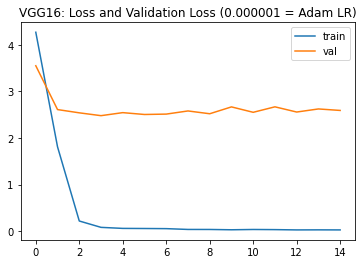

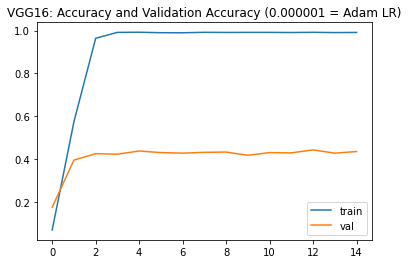

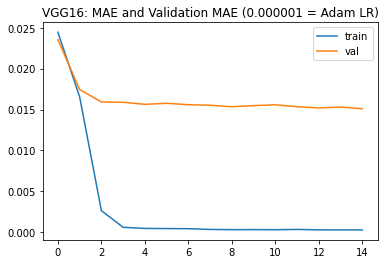

In [ ]:


plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('VGG16: Loss and Validation Loss ''(0.000001 = Adam LR)')
plt.legend();
plt.savefig('/content/drive/MyDrive/CPEN391_team_penguin/loss.png')
plt.show()

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title('VGG16: Accuracy and Validation Accuracy (0.000001 = Adam LR)')
plt.legend();
plt.savefig('/content/drive/MyDrive/CPEN391_team_penguin/accuracy.png')
plt.show()

plt.plot(hist.history['mae'], label='train')
plt.plot(hist.history['val_mae'], label='val')
plt.title('VGG16: MAE and Validation MAE (0.000001 = Adam LR)')
plt.legend();
plt.savefig('/content/drive/MyDrive/CPEN391_team_penguin/mae.png')
plt.show()

In [ ]:
hist.history['val_accuracy']
max_acc = max(hist.history['val_accuracy'])
min_acc = min(hist.history['val_accuracy'])
saved_accuracy = max_acc if (1-min_acc)<max_acc else min_acc
saved_accuracy

0.17499999701976776

In [ ]:
max_acc

0.4424999952316284

In [ ]:
model.save(f'/content/drive/MyDrive/CPEN391_team_penguin/Model/save{max_acc}acc')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CPEN391_team_penguin/Model/save0.4424999952316284acc/assets
